### Исследование поведения пользователей с целью выявления закономерностей для построения модели монетизации игрового приложения

### Материалы
1. https://yadi.sk/i/NVb5CIVKbzuyxQ - ссылка на презентацию
2. https://public.tableau.com/views/games_dash_russian/Dashboard1?:language=en&:display_count=y&:origin=viz_share_link - дашборд (набор 1)

<b>Цель исследования:</b> сформировать модель монетизации игрового приложения.<br>

Имеются следующие данные:
1. game_actions.csv - датасет с совершенными пользователями событиями:
    * event_datetime — время события
    * event — одно из трёх событий:
        - `building` — объект построен
        - `finished_stage_1` — первый уровень завершён
        - `project` — проект завершён
    * building_type — один из трёх типов здания:
        - `assembly_shop` — сборочный цех
        - `spaceport` — космопорт
        - `research_center` — исследовательский центр
    * user_id — идентификатор пользователя
    * project_type — тип реализованного проекта
    _______________
2. ad_cost.csv - данные о маркетинговых затратах на привлечение пользователей:
    * day - день, в который был совершен клик по объявлению
    * source - источник трафика
    * cost - стоимость кликов
    ________________
3. user_source.csv - информацияя об источниках, благодаря которым пришли наши пользователи:
    * user_id - идентификатор пользователя
    * source - источник, с которого пришёл пользователь, установивший приложение

### Часть 1. Предобработка данных
1. [Импорт библиотек](#Section1.1)
2. [Чтение и изучение данных на предмет пропусков, дубликатов. Изменение типов данных](#Section1.2)
___________________

### Часть 2. Исследовательский анализ данных
1. [Разработка профиля пользователей со следующими данными:](#Section2.1)
    * `user_id` - идентификатор пользователя
    * `first_event`, `last_event` - дата совершения первого и последнего событий
    * `building_amount` - количество построек
    * `difference` - длительность прохождения уровня, либо время, прошедшее с первого до последнего события(в случае непрохождения уровня)
    * `complited` - индикатор того, прошел пользователь уровень, либо нет c тремя возможными значениями:
        - project
        - without project
        - level is not complited
    * `source` - из какого источника пришел пользователь
    * `costs` - сколько потратили на его привлечение
2. [Изучить разницу времени, затраченного на прохождение уровня для пользователей разных групп по признаку  `complited`](#Section2.2)
3. [Изучить разницу по количеству построек для пользователей разных групп по признаку  `complited`. Исходя из среднего значения количества построек у тех, кто не завершил уровень, установить порог, начиная с которого можно считать пользователя вовлеченным в игровой процесс.](#Section2.3)
4. [Изучить разницу между количеством действий в день, совершаемых пользователями разных групп.](#Section2.4)
5. [Из тех, кто не завершил уровень попытаться выделить тех, кто не успел его пройти за промежуток времени, за который присутствуют данные и тех, кто покинул игру окончательно. Приблизительно оценить, сколько пользователей потеряно.](#Section2.5)
___________________
### Часть 3. Статистический анализ
1. [Проверка гипотез 1:](#Section3.1)
      * HO - время прохождения уровня у пользователей, которые заканчивают уровень через реализацию проекта, не отличается от времени  пользователей, которые заканчивают уровень победой над другим игроком.
      * Н1 - время прохождения уровня различается у пользователей разных групп
2. [Проверка гипотез 2:](#Section3.2)
    * Н0 - количество построек у пользователей обеих групп не различается
    * Н1 - количество построек различно
    
_____________________________________


### Часть 4. Создание модели монетизации
1. [Посчитать общие маркетинговые затраты](#Section4.1)
2. В случае рекламы в виде баннера, посчитать минимальный cpm(цена за 1000 просмотров) для того, чтобы покрыть маркетинговые затраты. Сравнить его со средним cpm по отрасли. 
   * [Сценарий 1](#Section4.2.1) : Счиать, что баннер мы можем показывать, начиная с первого захода игрока на страницу с постройками, т.к. он не отвлекают от игорового процесса и является наименее раздражающим)))
   * [Сценарий 2](#Section4.2.2): Считать , что баннер мы начинаем показывать с момента достижения пользователем порога вовлеченности
3. Расчитать варианты показа видеорекламы при выходе из игры:
    * [Сценарий 1](#Section4.3.1) : Считать, что рекламу показываем, начиная с первого выхода из игры
    * [Сценарий 2](#Section4.3.2): Считать , что рекламу показываем с момента достижения пользователем порога вовлеченности


_______________________
### [Общий вывод и рекомендации](#Section5)

### Часть 1. Предобработка данных

<a id = 'Section1.1'></a>
###### Импорт библиотек.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
!pip install pycbrf
from pycbrf.toolbox import ExchangeRates
import datetime
from io import BytesIO
import requests

<a id = 'Section1.2'></a>
##### Чтение и изучение данных на предмет пропусков, дубликатов. Изменение типов данных.

<b>Функция для описания датасета:

In [2]:
def read_csv(id):
    spreadsheet_id = id
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    data = pd.read_csv(BytesIO(r.content))
    print('Первые строки таблицы')
    display(data.head(5))
    print('Последние строки таблицы')
    display(data.tail(5))
    print('Информация о таблице')
    display(data.info(5))
    print('Проверка на дубликаты:')
    display(data.duplicated().sum())
    return data

<b>Дататсет 'game_actions'

In [3]:
game_actions = read_csv('id_for_game_actions')

Первые строки таблицы


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 0:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 0:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 0:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 0:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 0:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


Последние строки таблицы


,event_datetime,event,building_type,user_id,project_type
135635,2020-06-05 0:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 2:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 8:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN
135639,2020-06-05 12:32:49,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN


Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

Проверка на дубликаты:


1

<b>Смотрим на характер пропусков:

In [4]:
game_actions.query('event == "project"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1866 entries, 47121 to 135630
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   event_datetime  1866 non-null   object
 1   event           1866 non-null   object
 2   building_type   0 non-null      object
 3   user_id         1866 non-null   object
 4   project_type    1866 non-null   object
dtypes: object(5)
memory usage: 87.5+ KB


In [5]:
game_actions.query('event == "building"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127957 entries, 0 to 135637
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  127957 non-null  object
 1   event           127957 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         127957 non-null  object
 4   project_type    0 non-null       object
dtypes: object(5)
memory usage: 5.9+ MB


<font color = 'purple'>Видно, что значения в project_type имеются в случае event == "project". <br>
То же касается столбца building_type. Он заполнен в случае 'event == "building"


<b>Меняем тип данных и удаляем дубликат:

In [6]:
game_actions = game_actions.drop_duplicates()
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.2+ MB


<b>Вывод:</b><br>
Датасет `game_actions` имеет 5 столбцов, все - типа object,  и 135640 строк. Имеются пропуски в солбцах building_type  и building_type. Также имеется 1 дублированная строка.<br>
Тип данных был изменен в столбце event_datetime на datetime64[ns]. Дубликат удален, пропуски оставлены без изменений, т.к. связаны не с недостатком данных, а с характером событий.

<b>Дататсет 'ad_costs'

In [7]:
ad_costs = read_csv('id_for_ad_costs')

Первые строки таблицы


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


Последние строки таблицы


,source,day,cost
23,youtube_channel_reklama,2020-05-05,147.041741
24,youtube_channel_reklama,2020-05-06,88.506074
25,youtube_channel_reklama,2020-05-07,55.740645
26,youtube_channel_reklama,2020-05-08,40.217907
27,youtube_channel_reklama,2020-05-09,23.314669


Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

Проверка на дубликаты:


0

<b>Меняем тип данных:

In [8]:
ad_costs['day'] = pd.to_datetime(ad_costs['day'])
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


<b>Вывод:</b><br>
Датасет `ad_costs` имеет 3 столбцa, 2 - типа object, 1 - float  и 28 строк. Пропусков, дубликатов нет.<br>
Тип данных был изменен в столбце day на datetime64[ns]. 

<b>Дататсет 'user_source'

In [9]:
user_source = read_csv('id_for_user_source')

Первые строки таблицы


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


Последние строки таблицы


,user_id,source
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts
13575,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,facebook_ads


Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

Проверка на дубликаты:


0

<b>Вывод:</b><br>
Датасет `user_source` имеет 2 столбцa, все - типа object,  и 13576 строк. Пропусков, дубликатов нет.

### Часть 2. Исследовательский анализ данных

<a id = 'Section2.1'></a>
##### Разработка профиля пользователей

* `user_id` - идентификатор пользователя
* `first_event`, `last_event` - дата совершения первого и последнего событий
* `events_amount`
* `buildings_amount` - количество построек
* `difference` - длительность прохождения уровня, либо время, прошедшее с первого до последнего события(в случае непрохождения уровня)
* `complited` - индикатор того, прошел пользователь уровень, либо нет c тремя возможными значениями:
    - project
    - without project
    - level is not complited
* `source` - из какого источника пришел пользователь
* `costs` - сколько потратили на его привлечение

In [10]:
profile = (
    game_actions.groupby('user_id')
    .agg({'building_type':'count',
           'event':'count',
           'event_datetime': ['first','last']})
)
profile.columns = ['buildings_amount','events_amount','first_event','last_event']
profile['difference_min'] = ((profile['last_event'] - profile['first_event'])/np.timedelta64(1, 's'))/60
profile

,buildings_amount,events_amount,first_event,last_event,difference_min
user_id,,,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,13,2020-05-06 01:07:37,2020-05-20 11:26:06,20778.483333
00151b4f-ba38-44a8-a650-d7cf130a0105,9,9,2020-05-06 03:09:12,2020-05-18 10:46:52,17737.666667
001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,4,2020-05-05 18:08:52,2020-05-14 09:21:27,12432.583333
001d39dc-366c-4021-9604-6a3b9ff01e25,8,9,2020-05-05 21:02:05,2020-05-12 07:40:47,9278.700000
002f508f-67b6-479f-814b-b05f00d4e995,12,12,2020-05-05 13:49:58,2020-05-22 02:46:45,23816.783333
...,...,...,...,...,...
ffef4fed-164c-40e1-bde1-3980f76d0fb5,9,10,2020-05-04 01:58:59,2020-05-11 22:15:54,11296.916667
fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16,16,2020-05-04 11:58:14,2020-05-14 10:11:36,14293.366667
fffb626c-5ab6-47c9-8113-2062a2f18494,9,10,2020-05-04 02:05:09,2020-05-12 13:01:52,12176.716667


<b>Разница между количеством событий и количеством построек

In [11]:
profile['events_buildings_difference'] = profile['events_amount'] -  profile['buildings_amount'] 
profile

,buildings_amount,events_amount,first_event,last_event,difference_min,events_buildings_difference
user_id,,,,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,13,2020-05-06 01:07:37,2020-05-20 11:26:06,20778.483333,0
00151b4f-ba38-44a8-a650-d7cf130a0105,9,9,2020-05-06 03:09:12,2020-05-18 10:46:52,17737.666667,0
001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,4,2020-05-05 18:08:52,2020-05-14 09:21:27,12432.583333,0
001d39dc-366c-4021-9604-6a3b9ff01e25,8,9,2020-05-05 21:02:05,2020-05-12 07:40:47,9278.700000,1
002f508f-67b6-479f-814b-b05f00d4e995,12,12,2020-05-05 13:49:58,2020-05-22 02:46:45,23816.783333,0
...,...,...,...,...,...,...
ffef4fed-164c-40e1-bde1-3980f76d0fb5,9,10,2020-05-04 01:58:59,2020-05-11 22:15:54,11296.916667,1
fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16,16,2020-05-04 11:58:14,2020-05-14 10:11:36,14293.366667,0
fffb626c-5ab6-47c9-8113-2062a2f18494,9,10,2020-05-04 02:05:09,2020-05-12 13:01:52,12176.716667,1


In [12]:
profile['events_buildings_difference'].unique()

array([0, 1, 2], dtype=int64)

<b>Посмотрим, нет ли тех, у кого событие "finished_stage_1" присутствует больше 1 раза:

In [13]:
game_actions.query('event == "finished_stage_1"').groupby('user_id')['event'].count().unique()

array([1], dtype=int64)

<font color = 'purple'>Все в порядке, событие окончания уровня присутствует у пользователей по 1 разу

<font color = 'purple'>По сути, разница между количеством построек и количеством событий и является индикатором того, пройден или не пройден уровень и каким образом. Если разница = 0, то уровень не пройден, если 1(событие "finished_stage_1") - , то уровень пройден без реализации проекта, 2(события "project" и "finished_stage_1")- уровень пройден с реализацией проекта.

<b>Функция для создания столбца 'complited':

In [14]:
def projet(row):
    complited = row['events_buildings_difference']
    if complited == 0:
        return 'level is not complited'
    if complited == 1:
        return 'without project'
    if complited == 2:
        return 'project'

        

In [15]:
profile['complited'] = profile.apply(projet, axis = 1)
profile

,buildings_amount,events_amount,first_event,last_event,difference_min,events_buildings_difference,complited
user_id,,,,,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,13,2020-05-06 01:07:37,2020-05-20 11:26:06,20778.483333,0,level is not complited
00151b4f-ba38-44a8-a650-d7cf130a0105,9,9,2020-05-06 03:09:12,2020-05-18 10:46:52,17737.666667,0,level is not complited
001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,4,2020-05-05 18:08:52,2020-05-14 09:21:27,12432.583333,0,level is not complited
001d39dc-366c-4021-9604-6a3b9ff01e25,8,9,2020-05-05 21:02:05,2020-05-12 07:40:47,9278.700000,1,without project
002f508f-67b6-479f-814b-b05f00d4e995,12,12,2020-05-05 13:49:58,2020-05-22 02:46:45,23816.783333,0,level is not complited
...,...,...,...,...,...,...,...
ffef4fed-164c-40e1-bde1-3980f76d0fb5,9,10,2020-05-04 01:58:59,2020-05-11 22:15:54,11296.916667,1,without project
fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16,16,2020-05-04 11:58:14,2020-05-14 10:11:36,14293.366667,0,level is not complited
fffb626c-5ab6-47c9-8113-2062a2f18494,9,10,2020-05-04 02:05:09,2020-05-12 13:01:52,12176.716667,1,without project


<b>Добавим информацию о том, из какого источника пришел пользователь:

In [16]:
profile = profile.join(user_source.set_index('user_id'))
profile

,buildings_amount,events_amount,first_event,last_event,difference_min,events_buildings_difference,complited,source
user_id,,,,,,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,13,2020-05-06 01:07:37,2020-05-20 11:26:06,20778.483333,0,level is not complited,facebook_ads
00151b4f-ba38-44a8-a650-d7cf130a0105,9,9,2020-05-06 03:09:12,2020-05-18 10:46:52,17737.666667,0,level is not complited,yandex_direct
001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,4,2020-05-05 18:08:52,2020-05-14 09:21:27,12432.583333,0,level is not complited,youtube_channel_reklama
001d39dc-366c-4021-9604-6a3b9ff01e25,8,9,2020-05-05 21:02:05,2020-05-12 07:40:47,9278.700000,1,without project,instagram_new_adverts
002f508f-67b6-479f-814b-b05f00d4e995,12,12,2020-05-05 13:49:58,2020-05-22 02:46:45,23816.783333,0,level is not complited,facebook_ads
...,...,...,...,...,...,...,...,...
ffef4fed-164c-40e1-bde1-3980f76d0fb5,9,10,2020-05-04 01:58:59,2020-05-11 22:15:54,11296.916667,1,without project,instagram_new_adverts
fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16,16,2020-05-04 11:58:14,2020-05-14 10:11:36,14293.366667,0,level is not complited,facebook_ads
fffb626c-5ab6-47c9-8113-2062a2f18494,9,10,2020-05-04 02:05:09,2020-05-12 13:01:52,12176.716667,1,without project,yandex_direct


<b>Посчитаем стоимость привлечения каждого пользователя:

In [17]:
profile['first_event_date'] = profile['first_event'].dt.date.astype('datetime64[ns]')

In [18]:
users_amount = profile.reset_index().groupby(['first_event_date','source'])['user_id'].nunique().to_frame(name = 'users_amount')
users_amount = users_amount.join(ad_costs.rename(columns = {'day':'first_event_date'}).set_index(['first_event_date','source']))

In [19]:
users_amount['cost_for_user'] = users_amount['cost']/users_amount['users_amount']
users_amount

users_amount        cost  \
first_event_date source                                              
2020-05-04       facebook_ads                     1184  548.354480   
                 instagram_new_adverts            1452  502.925451   
                 yandex_direct                    2078  554.651494   
                 youtube_channel_reklama          1146  259.073224   
2020-05-05       facebook_ads                      694  260.185754   
                 instagram_new_adverts             796  313.970984   
                 yandex_direct                    1208  308.232990   
                 youtube_channel_reklama           663  147.041741   
2020-05-06       facebook_ads                      345  177.982200   
                 instagram_new_adverts             472  173.071145   
                 yandex_direct                     664  180.917099   
                 youtube_channel_reklama           366   88.506074   
2020-05-07       facebook_ads                      224  111.766796   
                 instagram_new_adverts             270  109.915254   
                 yandex_direct                     395  114.429338   
                 youtube_channel_reklama           220   55.740645   
2020-05-08       facebook_ads                      139   68.009276   
                 instagram_new_adverts             175   71.578739   
                 yandex_direct                     239   62.961630   
                 youtube_channel_reklama           135   40.217907   
2020-05-09       facebook_ads                       84   38.723350   
                 instagram_new_adverts             112   46.775400   
                 yandex_direct                     144   42.779505   
                 youtube_channel_reklama           100   23.314669   
2020-05-10       facebook_ads                       56         NaN   
                 instagram_new_adverts              70         NaN   
                 yandex_direct                      89         NaN   
                 youtube_channel_reklama            56         NaN   

                                          cost_for_user  
first_event_date source                                  
2020-05-04       facebook_ads                  0.463137  
                 instagram_new_adverts         0.346367  
                 yandex_direct                 0.266916  
                 youtube_channel_reklama       0.226067  
2020-05-05       facebook_ads                  0.374907  
                 instagram_new_adverts         0.394436  
                 yandex_direct                 0.255160  
                 youtube_channel_reklama       0.221782  
2020-05-06       facebook_ads                  0.515890  
                 instagram_new_adverts         0.366676  
                 yandex_direct                 0.272466  
                 youtube_channel_reklama       0.241820  
2020-05-07       facebook_ads                  0.498959  
                 instagram_new_adverts         0.407094  
                 yandex_direct                 0.289695  
                 youtube_channel_reklama       0.253367  
2020-05-08       facebook_ads                  0.489275  
                 instagram_new_adverts         0.409021  
                 yandex_direct                 0.263438  
                 youtube_channel_reklama       0.297910  
2020-05-09       facebook_ads                  0.460992  
                 instagram_new_adverts         0.417637  
                 yandex_direct                 0.297080  
                 youtube_channel_reklama       0.233147  
2020-05-10       facebook_ads                       NaN  
                 instagram_new_adverts              NaN  
                 yandex_direct                      NaN  
                 youtube_channel_reklama            NaN

In [20]:
profile = (
    profile.reset_index().set_index(['first_event_date','source'])
    .join(users_amount[['cost_for_user']], how = 'left')
).reset_index().set_index('user_id')


<b>Посмотрим, сколько в среднем обходится привлечение одного пользователя из определенного источника:

In [21]:
profile.groupby(['source','first_event_date'] )['cost_for_user'].first().reset_index().groupby('source')['cost_for_user'].mean()

source
facebook_ads               0.467194
instagram_new_adverts      0.390205
yandex_direct              0.274126
youtube_channel_reklama    0.245682
Name: cost_for_user, dtype: float64

In [22]:
profile.reset_index().groupby('source')['user_id'].count().sort_values()

source
youtube_channel_reklama    2686
facebook_ads               2726
instagram_new_adverts      3347
yandex_direct              4817
Name: user_id, dtype: int64

<font color = 'purple'>Самые 'дорогие' пользователи приходят из facebook. Наиболее дешево размещать рекламу на youtube_channel_reklama. В то же время, из youtube_channel_reklama приходит наименьшее количество пользователей. Больше всего пользователей приходит из instagram_new_adverts и yandex_direct.  Имеет смысл обратить на это внимание и , возможно, перераспредилить финансирование.<br>
Временные рамки таблицы с затратами не совпадают с таковыми в таблице с действиями пользователей. В таблице ad_costs нет данных за 2020-05-10. В связи с этим у нас появилось некоторое количество пропусков, которые никак не помешают нам в дальнейших исследованиях. При маркетинговых расчетах мы не будем использовать данные о пользователях, у которых не известна стоимость их привлечения.

<a id = 'Section2.2'></a>
##### Изучение ранизницы по времени, затраченного на прохождение уровня для пользователей разных групп по признаку  `complited`

<b>Пострим boxplot параметра `difference` по всем пользователям:

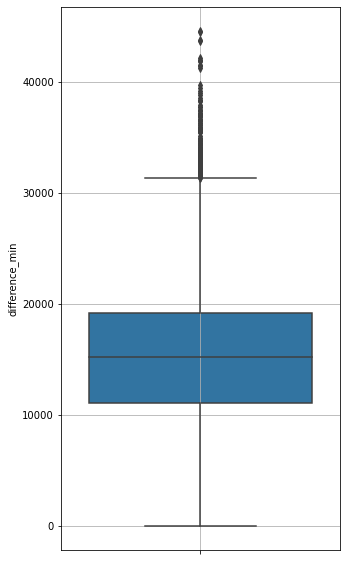

In [23]:

fig,ax = plt.subplots(figsize = (5,10))
sns.boxplot(y="difference_min", data=profile)
plt.grid()

In [24]:
profile['difference_min'].describe()

count    13576.000000
mean     15373.126320
std       6264.678200
min          0.000000
25%      11073.645833
50%      15150.875000
75%      19168.866667
max      44518.883333
Name: difference_min, dtype: float64

<font color = 'purple'>Видим, что минимальное значение разницы во времени 0. Посмотрим, сколько таких пользователей.

In [25]:
profile.reset_index().query('difference_min == 0')['user_id'].count()

57

<font color = 'purple'>Видим, что таких пользователей немного, не стоит их учитывать в дальнейшем анализе. Причина появления таких поьзователей требует дополнительного уточнения.

In [26]:
profile_final = profile.query('difference_min != 0')
profile_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13519 entries, 004074f8-251a-4776-922c-8348dca1a2f6 to fc1d6e36-b642-41b7-a302-218d24f3b991
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   first_event_date             13519 non-null  datetime64[ns]
 1   source                       13519 non-null  object        
 2   buildings_amount             13519 non-null  int64         
 3   events_amount                13519 non-null  int64         
 4   first_event                  13519 non-null  datetime64[ns]
 5   last_event                   13519 non-null  datetime64[ns]
 6   difference_min               13519 non-null  float64       
 7   events_buildings_difference  13519 non-null  int64         
 8   complited                    13519 non-null  object        
 9   cost_for_user                13254 non-null  float64       
dtypes: datetime64[ns](3), float64(2), int64(3), o

<b>Пострим boxplot параметра `difference` по всем пользователям в разбивке по принципу `complited`:

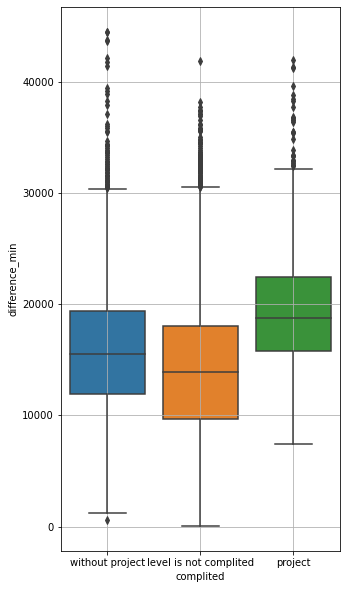

In [27]:
fig,ax = plt.subplots(figsize = (5,10))
sns.boxplot(y="difference_min", x = 'complited', data=profile_final)
plt.grid()

<font color = 'purple'>Видим, что разница между первым и последним событием меньше всех у тех, кто уровени не завершил. Из тех, кто его прошел, больше времени тратят те, кто реализует проект.<br>
Также видно, что  пользователи, `difference_min` которых больше 40000мин единичны. Эти значения можно отнести к выбросам и не учитывать их в дальнейшем.

<b>Посмотрим, как много таких пользователей:
    

In [28]:
profile_final.reset_index().query('difference_min > 40000')['user_id'].count()

11

In [29]:
profile_final = profile_final.reset_index().query('difference_min < 40000')
profile_final.to_csv('profile_final.csv')

<b>Смаотрим долю пользователей, потерянную в результате фильтрации:

In [30]:
(profile.reset_index()['user_id'].nunique() - profile_final.reset_index()['user_id'].nunique())\
/profile.reset_index()['user_id'].nunique()

0.005008839127872717

<font color = 'purple'>Как видим, отфильтровано менее одного процета данных.

<b>Вывeведем метод describe() для параметра `difference_min`для всех трех групп:

In [31]:
def describe(column):
    for group in profile_final['complited'].unique():
        print(group)
        display(profile_final.query('complited == @group')[column].describe())

In [32]:
profile_final['difference_days'] = (profile_final['difference_min']/60/24).round(2)
print('Время в минутах')
describe('difference_min')
print('Время в днях')
describe('difference_days')

Время в минутах
without project


count     3944.000000
mean     15942.240437
std       5790.943692
min        579.016667
25%      11939.950000
50%      15525.083333
75%      19344.850000
max      39446.033333
Name: difference_min, dtype: float64

level is not complited


count     7701.000000
mean     14195.688612
std       6152.363859
min         37.450000
25%       9639.366667
50%      13883.616667
75%      18017.916667
max      38220.516667
Name: difference_min, dtype: float64

project


count     1863.000000
mean     19345.152442
std       4976.165324
min       7402.450000
25%      15768.758333
50%      18754.400000
75%      22404.783333
max      39660.566667
Name: difference_min, dtype: float64

Время в днях
without project


count    3944.000000
mean       11.070925
std         4.021465
min         0.400000
25%         8.290000
50%        10.780000
75%        13.432500
max        27.390000
Name: difference_days, dtype: float64

level is not complited


count    7701.000000
mean        9.858087
std         4.272475
min         0.030000
25%         6.690000
50%         9.640000
75%        12.510000
max        26.540000
Name: difference_days, dtype: float64

project


count    1863.000000
mean       13.434096
std         3.455653
min         5.140000
25%        10.950000
50%        13.020000
75%        15.555000
max        27.540000
Name: difference_days, dtype: float64

##### Вывод:
После изучения ранизницы по времени, затраченного на прохождение уровня для пользователей разных групп по признаку  `complited` можно сказать, что в среднем, минимальное время нахождения в игре имеют пользователи группы "level is not complited", что ожидаемо. Из двух групп пользователей завершивших уровень, меньше времени, в стеднем, тратят те, кто прошел уровень через победу над другим игроком. Те же, кто реализовал проект, проходили уровень дольше.<br>
_____________________________
Средние значения параметра difference_min:
1. level is not complited - 14195мин или 9.9 дней
2. without project - 15942мин или 11 дней
3. project - 19345 мин или 13.5 дней
____________________
Медианные значения параметра difference_min:
1. level is not complited - 13883мин или 9.6 дней
2. without project - 15525мин или 10.8 дня
3. project - 18754 мин или 13 дней

Медианные значения немного меньше средних, распределение несколько скошено вправо.

<a id = 'Section2.3'></a>
##### Изучение разницы по количеству построек для пользователей разных групп по признаку  `complited`.

In [33]:
profile_final['buildings_amount'].describe()

count    13508.000000
mean         9.458543
std          3.830260
min          2.000000
25%          6.000000
50%         10.000000
75%         12.000000
max         20.000000
Name: buildings_amount, dtype: float64

<b>Пострим  countplot параметра `buildings_amount` по всем пользователям:

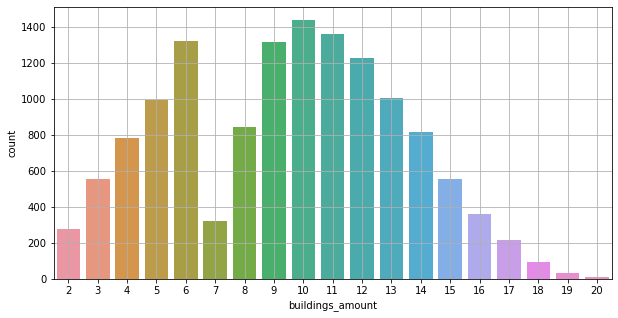

In [34]:
fig,ax = plt.subplots(figsize = (10,5))
sns.countplot(x = 'buildings_amount', data=profile_final)
plt.grid()

<font color = 'purple'>Имеется 2 пиковых значения - 6 и 10 построек. Предположу, что это пики для разных групп. Ниже проверим)

<b>Пострим  countplot параметра `buildings_amount` в разбивке по признаку `complited`:

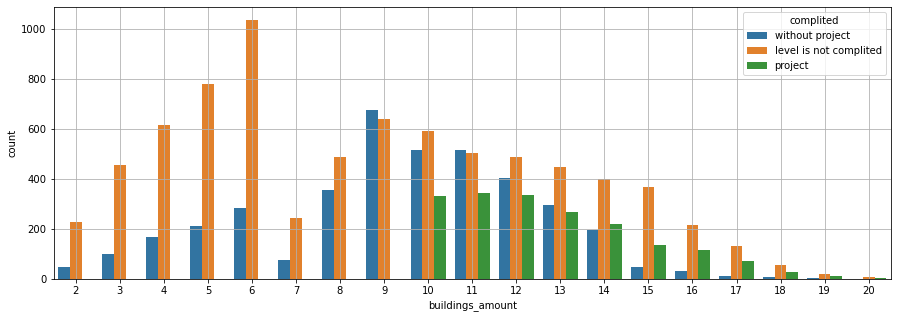

In [35]:
fig,ax = plt.subplots(figsize = (15,5))
sns.countplot(x = 'buildings_amount', hue = 'complited', data=profile_final)
plt.grid()

<b>Вывeведем метод describe() для параметра `buildings_amount` для всех трех групп:

In [36]:
describe('buildings_amount')

without project


count    3944.000000
mean        9.407201
std         3.059062
min         2.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        19.000000
Name: buildings_amount, dtype: float64

level is not complited


count    7701.000000
mean        8.713414
std         4.098123
min         2.000000
25%         5.000000
50%         9.000000
75%        12.000000
max        20.000000
Name: buildings_amount, dtype: float64

project


count    1863.000000
mean       12.647343
std         2.163225
min        10.000000
25%        11.000000
50%        12.000000
75%        14.000000
max        20.000000
Name: buildings_amount, dtype: float64

##### Вывод:
Видим, что наибольшее количество игроков из тех, что не прошли уровень, останавливаются после строительства 6 постройки. После 7 же останавливаются реже. В связи этим, я бы предложила принять количество построек > 6 за порог вовлеченности пользователя в игру, несмотря на то, что среднее выше и составляет 8.<br>  
В остальных группах отличие моды и среднего не так велико. В среднем те, кто проходит уровень через победу над другими игроками строят меньше (9), чем те, что проходят уровень через реализацию проекта(12).

<a id = 'Section2.4'></a>
##### Изучение разницы между количеством действий в день, совершаемых пользователями разных групп

<b>Cоздадим в таблице game_actions столбец с датой совершения события:

In [37]:
game_actions['date'] = game_actions['event_datetime'].dt.date.astype('datetime64[ns]')

<b>Выберем пользователей, которые присутствуют в талице profile_final:

In [38]:
correct_users = profile_final['user_id'].unique()
game_actions_new = game_actions.query('user_id in @correct_users')

<b>Посчитаем среденее количество действий, совершаемых в день и количество дней, в которые пользователь играет

In [39]:
events_per_day = (
    game_actions_new
    .groupby(['user_id','date'])['event']
    .count().to_frame(name = 'events_amount_per_day').reset_index()
    .groupby('user_id').agg({'events_amount_per_day': ['count','mean']})
)
events_per_day.columns = ['amount_of_playing_days','avg_events_amount_per_day']

<b>Добавим информацию к профилю:

In [40]:
profile_final = profile_final.set_index('user_id').join(events_per_day)

In [41]:
profile_final

,first_event_date,source,buildings_amount,events_amount,first_event,last_event,difference_min,events_buildings_difference,complited,cost_for_user,difference_days,amount_of_playing_days,avg_events_amount_per_day
user_id,,,,,,,,,,,,,
004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04,facebook_ads,12,13,2020-05-04 01:07:35,2020-05-16 19:57:40,18410.083333,1,without project,0.463137,12.78,8,1.625000
00440efd-aa50-4b4b-aae8-ffcd1782729d,2020-05-04,facebook_ads,7,7,2020-05-04 07:20:40,2020-05-09 10:33:13,7392.550000,0,level is not complited,0.463137,5.13,5,1.400000
0099a74d-bafc-404f-ae47-5c901a06d108,2020-05-04,facebook_ads,12,12,2020-05-04 14:53:02,2020-05-14 20:11:03,14718.016667,0,level is not complited,0.463137,10.22,7,1.714286
00eed4e1-a7bd-46c8-a563-862ce3c916d6,2020-05-04,facebook_ads,8,8,2020-05-04 12:39:31,2020-05-13 00:32:46,12233.250000,0,level is not complited,0.463137,8.50,5,1.600000
00ef3286-af82-49d8-9710-d4a087912bfc,2020-05-04,facebook_ads,10,10,2020-05-04 19:52:44,2020-05-13 06:21:59,12149.250000,0,level is not complited,0.463137,8.44,7,1.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
e88a413a-f5f0-473f-94e0-e33ebab998db,2020-05-10,youtube_channel_reklama,4,5,2020-05-10 19:10:19,2020-05-16 06:38:57,7888.633333,1,without project,NaN,5.48,3,1.666667
f9d9ad45-c603-413b-abdd-c2437efebd66,2020-05-10,youtube_channel_reklama,2,2,2020-05-10 01:16:46,2020-05-10 05:52:08,275.366667,0,level is not complited,NaN,0.19,1,2.000000
fb3d6bc4-3c24-4790-ab5f-67585d94ca19,2020-05-10,youtube_channel_reklama,9,10,2020-05-10 09:20:24,2020-05-22 05:27:33,17047.150000,1,without project,NaN,11.84,9,1.111111


<b>Пострим boxplot параметра avg_events_amount_per_day по всем пользователям в разбивке по принципу complited:


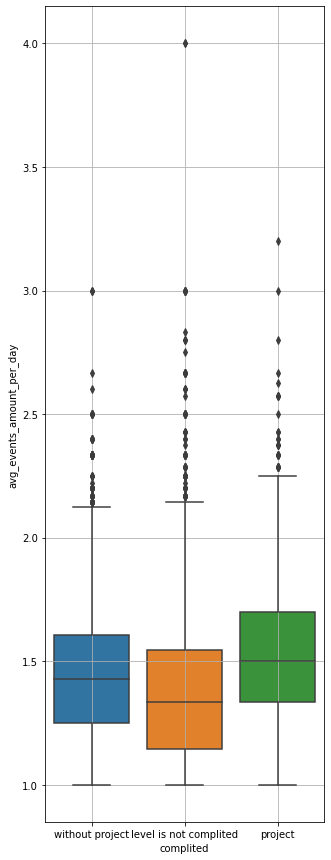

In [42]:

fig,ax = plt.subplots(figsize = (5,15))
sns.boxplot(y= "avg_events_amount_per_day", x = 'complited', data=profile_final)
plt.grid()


In [43]:
describe('avg_events_amount_per_day')

without project


count    3944.000000
mean        1.446654
std         0.277468
min         1.000000
25%         1.250000
50%         1.428571
75%         1.606250
max         3.000000
Name: avg_events_amount_per_day, dtype: float64

level is not complited


count    7701.000000
mean        1.371789
std         0.306124
min         1.000000
25%         1.142857
50%         1.333333
75%         1.545455
max         4.000000
Name: avg_events_amount_per_day, dtype: float64

project


count    1863.000000
mean        1.549654
std         0.275066
min         1.000000
25%         1.333333
50%         1.500000
75%         1.700000
max         3.200000
Name: avg_events_amount_per_day, dtype: float64

##### Вывод:
Пользователи, проходящие уровень через реализацию проекта, в среднем совершают больше событий в день, чем те, что проходят уровень путем победы над другим игроком. Из графиков видно, что значения, превосходящие 3 можно отнести к выбросам.

<a id = 'Section2.5'></a>
##### Из тех, кто не завершил уровень выделим  тех пользователей, кто не успел его пройти за промежуток времени, за который присутствуют данные и тех, кто покинул игру окончательно. Приблизительно оценить, сколько пользователей потеряно.

<b>Посмотрим раз в какое количество дней игроки  совершfют события

In [44]:
profile_final['frequency'] = (profile_final['difference_min']/60/24)/profile_final['amount_of_playing_days']

<b>Посмотрим describe по этому параметру:

In [45]:
describe('frequency')

without project


count    3944.000000
mean        1.540314
std         0.456991
min         0.201047
25%         1.224371
50%         1.462808
75%         1.781260
max         4.013146
Name: frequency, dtype: float64

level is not complited


count    7701.000000
mean        1.625460
std         0.565036
min         0.026007
25%         1.235787
50%         1.517030
75%         1.905446
max         4.565715
Name: frequency, dtype: float64

project


count    1863.000000
mean        1.400872
std         0.303415
min         0.734370
25%         1.177945
50%         1.353971
75%         1.575077
max         2.843675
Name: frequency, dtype: float64

<font color = 'purple'>В среднем пользователи заходят в приложение 1 раз в 1.5-2 дня. 

<b>Cмотрим, за какой период времени у нас есть данные:

In [46]:
game_actions['date'].describe()

count                  135639
unique                     33
top       2020-05-10 00:00:00
freq                    15207
first     2020-05-04 00:00:00
last      2020-06-05 00:00:00
Name: date, dtype: object

<b>Посчитаем сколько времени прошло с момента последнего события до 2020-06-05:

In [47]:
data_end = game_actions['date'].max()
profile_final['time_from_last_event_till_data_end'] =  (
    profile_final['last_event'].apply(lambda x: (data_end - x)/np.timedelta64(1,'s')/60 )
)

<font color = 'purple'>Я бы предложила принять тот факт, что если значение столбца > 7 дней(10080 часов) у пользователя, который не завершил уровень, то его можно отнести к пользователям, которые покинули игру. Остальные же просто могли не успеть закончить уровень до 2020-06-05.

<b>Выделим таких пользователей

In [48]:
lost_users = (
    profile_final.reset_index()
    .query('(complited == "level is not complited") & (time_from_last_event_till_data_end > 10080)')['user_id']
    .nunique()
)
lost_users

7662

<b>Посчитаем долю таких пользователей от тех, кто не закончил уровень и от всех пользователей:

In [49]:
print(
    'Доля пользователей( от тех, кто не закончил уровень), покинувших игру окончательно:'
    ,lost_users/profile_final.reset_index().query('complited == "level is not complited"')['user_id'].nunique()
)
print(
    'Доля пользователей, покинувших игру окончательно:'
    ,lost_users/profile_final.reset_index()['user_id'].nunique()
)

Доля пользователей( от тех, кто не закончил уровень), покинувших игру окончательно: 0.9949357226334242
Доля пользователей, покинувших игру окончательно: 0.5672194255256144


<b>Проведем когортный анализ и посмотрим Retantion Rate. Когортой, будем, считать пользователей, пришедших  в один и тот же день. Изменения RR также будем смотреть ежедневно

<b>Создаем когорты

In [50]:
cohort = game_actions.set_index('user_id')[['date']].join(profile[['first_event_date','complited']], how = 'left')
cohort

,date,first_event_date,complited
user_id,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,2020-05-06,level is not complited
0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,2020-05-06,level is not complited
0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,2020-05-06,level is not complited
0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-09,2020-05-06,level is not complited
0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-09,2020-05-06,level is not complited
...,...,...,...
ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-23,2020-05-08,project
ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-24,2020-05-08,project
ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-25,2020-05-08,project


<b>Считаем вермя жизни когорты

In [51]:
cohort['lifetime'] = ((cohort['date'] - cohort['first_event_date'])/np.timedelta64(1,'s')/60/60/24).astype('int')
#cohort.reset_index().pivot_table(index = 'first_event_date', columns = 'lifetime', values = 'user_id' , aggfunc = 'nunique')

In [52]:
cohort_grouped = cohort.reset_index().groupby(['first_event_date','lifetime'])['user_id'].nunique().reset_index()
cohort_grouped

,first_event_date,lifetime,user_id
0,2020-05-04,0,5860
1,2020-05-04,1,3021
2,2020-05-04,2,3204
3,2020-05-04,3,3412
4,2020-05-04,4,3564
...,...,...,...
194,2020-05-10,19,7
195,2020-05-10,20,3
196,2020-05-10,21,1
197,2020-05-10,22,1


<b>Смотрим изначальное число пользователей в когорте

In [53]:
initial_users_count = cohort_grouped[cohort_grouped['lifetime'] == 0][['first_event_date','user_id']].rename(columns={'user_id':'cohort_users'}) 
print(initial_users_count) 

    first_event_date  cohort_users
0         2020-05-04          5860
32        2020-05-05          3361
61        2020-05-06          1847
92        2020-05-07          1109
122       2020-05-08           688
149       2020-05-09           440
175       2020-05-10           271


In [54]:
cohort_grouped = cohort_grouped.merge(initial_users_count,on='first_event_date') 
cohort_grouped 

,first_event_date,lifetime,user_id,cohort_users
0,2020-05-04,0,5860,5860
1,2020-05-04,1,3021,5860
2,2020-05-04,2,3204,5860
3,2020-05-04,3,3412,5860
4,2020-05-04,4,3564,5860
...,...,...,...,...
194,2020-05-10,19,7,271
195,2020-05-10,20,3,271
196,2020-05-10,21,1,271
197,2020-05-10,22,1,271


In [55]:
cohort_grouped['first_event_date'] = cohort_grouped['first_event_date'].dt.date

<b>Считаем retention

In [56]:
cohort_grouped['retention'] = cohort_grouped['user_id']/cohort_grouped['cohort_users'] 
retention_pivot = cohort_grouped.pivot_table(index ='first_event_date',columns='lifetime',values='retention',aggfunc='sum') 

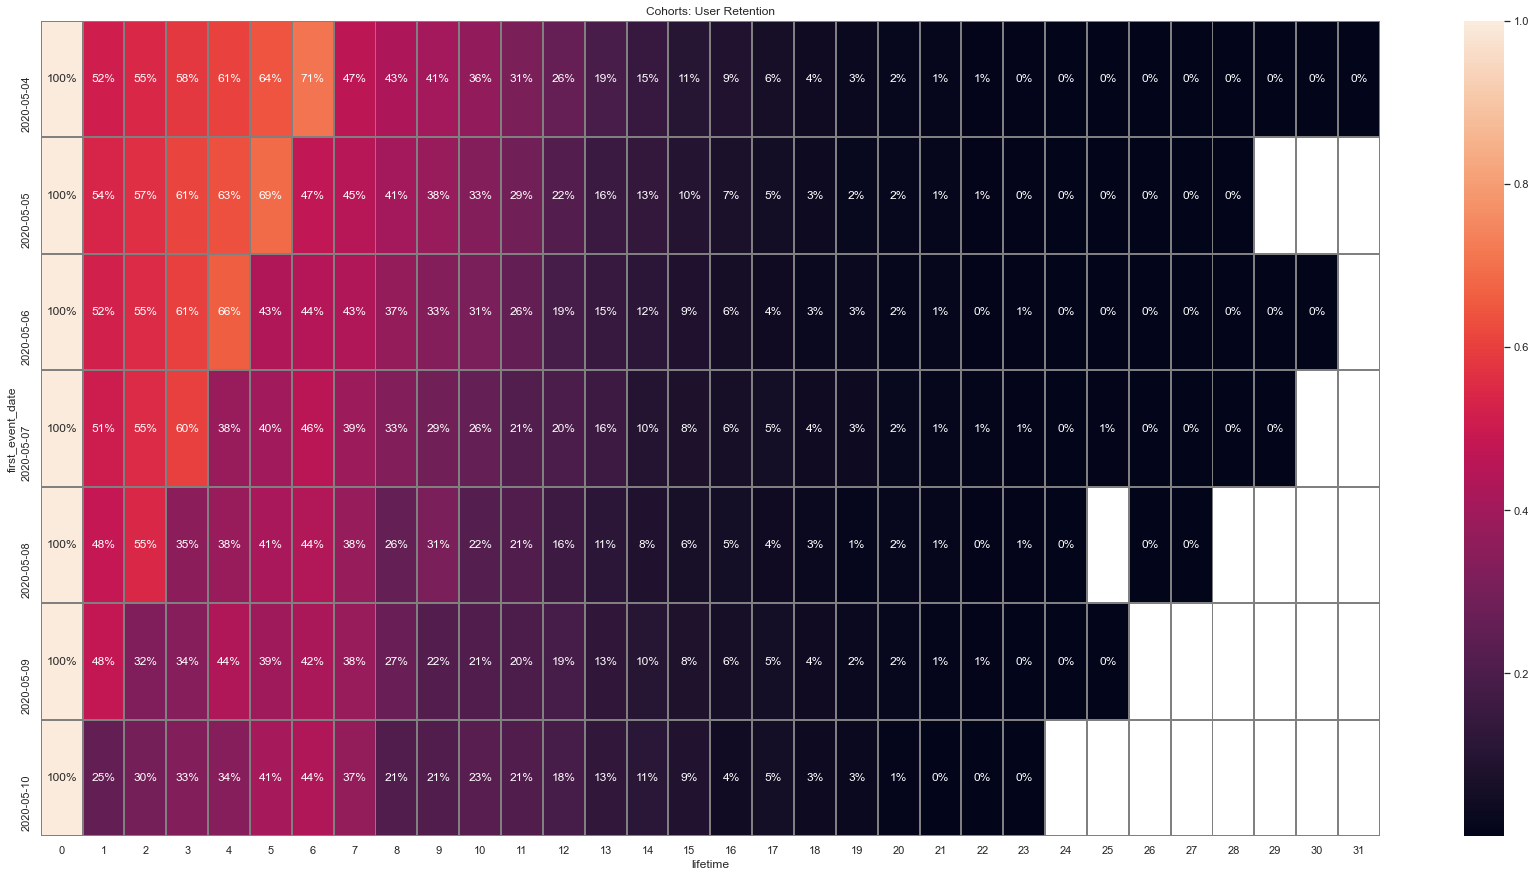

In [57]:
sns.set(style='white')
plt.figure(figsize=(30, 15))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.0%', linewidths=1, linecolor='gray')

##### Вывод: 
Из исследования, проведенного выше можно сделать неутешительный вывод о том, что игру покидает более половины пользователей, не закончив первый уровень.<br>
После проведения когортного анализа видно, что:
1. У пользователей 1 когорты наиболее высокие показатели RR
2. Во всех когортах RR снижается до 1 % к 21 дню жизни
3. Видно, что по всем когортам заметный спад RR происходит в один и тот же календарный день, а именно 2020-05-10. Судя по всему, это связано с остановкой маркетинговой активности. 

### Часть 3. Статистический анализ

<a id = 'Section3.1'></a>
##### Проверка гипотез 1:
* HO - время прохождения уровня у пользователей, которые заканчивают уровень через реализацию проекта, не отличается от времени  пользователей, которые заканчивают уровень победой над другим игроком.
* Н1 - время прохождения уровня различается у пользователей разных групп

<b>Напомним значения по выборкам:

In [58]:
describe('difference_min')

without project


count     3944.000000
mean     15942.240437
std       5790.943692
min        579.016667
25%      11939.950000
50%      15525.083333
75%      19344.850000
max      39446.033333
Name: difference_min, dtype: float64

level is not complited


count     7701.000000
mean     14195.688612
std       6152.363859
min         37.450000
25%       9639.366667
50%      13883.616667
75%      18017.916667
max      38220.516667
Name: difference_min, dtype: float64

project


count     1863.000000
mean     19345.152442
std       4976.165324
min       7402.450000
25%      15768.758333
50%      18754.400000
75%      22404.783333
max      39660.566667
Name: difference_min, dtype: float64

<font color = 'purple'>Для проверки гипотез применим непараметрический тест Уилкоксона-Манна-Уитни

In [59]:
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(profile_final.query('complited == "project"')['difference_min'],profile_final.query('complited == "without project"')['difference_min'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

p-значение:  1.3035518594845401e-107
Отвергаем нулевую гипотезу: разница статистически значима


##### Вывод: 
Получена статистически значимая разница между временем, требующимся на прохождение уровня по разным сценариям. При реализации проекта это время больше, чем при победе над другим игроком.

<a id = 'Section3.2'></a>
##### Проверка гипотез 2:
* Н0 - количество построек у пользователей обеих групп не различается
* Н1 - количество построек различно

In [60]:
describe('buildings_amount')

without project


count    3944.000000
mean        9.407201
std         3.059062
min         2.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        19.000000
Name: buildings_amount, dtype: float64

level is not complited


count    7701.000000
mean        8.713414
std         4.098123
min         2.000000
25%         5.000000
50%         9.000000
75%        12.000000
max        20.000000
Name: buildings_amount, dtype: float64

project


count    1863.000000
mean       12.647343
std         2.163225
min        10.000000
25%        11.000000
50%        12.000000
75%        14.000000
max        20.000000
Name: buildings_amount, dtype: float64

In [61]:
results =st.mannwhitneyu(profile_final.query('complited == "project"')['buildings_amount'],profile_final.query('complited == "without project"')['buildings_amount'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

p-значение:  2.090877648516665e-305
Отвергаем нулевую гипотезу: разница статистически значима


##### Вывод: 
Разница между количеством построек статистически значима. При реализации проекта игроки строят больше построек, чем при победе над другим игроком.

### Часть 4. Создание модели монетизации

<a id = 'Section4.1'></a>
##### Посчитать общие маркетинговые затраты

In [62]:
costs_for_all_users = profile['cost_for_user'].sum()
costs_for_all_users

4301.1251465039395

In [63]:
ad_costs['cost'].sum()

7603.576986788022

<font color = 'purple'>Видим, что значения не совпадают. Проверим, за какой период предоставлены данные:

In [64]:
ad_costs['day'].describe()

count                      28
unique                      7
top       2020-05-08 00:00:00
freq                        4
first     2020-05-03 00:00:00
last      2020-05-09 00:00:00
Name: day, dtype: object

In [65]:
profile['first_event_date'].describe()

count                   13576
unique                      7
top       2020-05-04 00:00:00
freq                     5860
first     2020-05-04 00:00:00
last      2020-05-10 00:00:00
Name: first_event_date, dtype: object

<font color = 'purple'>Временные границы не совпадают, значит, для расчетов необходимо убрать затраты за 2020-05-03, а из таблицы profile убрать пользователей, пришедших 2020-05-10 .<br>
Итоговая сумма на привлечение наших пользователей 4301 руб)

##### Посчитать минимальный cpm(цена за 1000 просмотров) для того, чтобы покрыть маркетинговые затраты. Сравнить его со средним cpm по отрасли.

<b>В данном случае речь пойдет о таком виде рекламы как баннер, который постоянно находится на странице с выбором постройки

<font color = 'purple'>Будем исходить из среднего cpm для Восточной Европы, который на платформе Андроид составляет 0.21$ по данным из сети.

<a id = 'Section4.2.1'></a>
##### Сценарий 1 :
Считаем, что баннер мы можем показывать, начиная с первого захода игрока на страницу с постройками, т.к. он не отвлекает от игорового процесса и является наименее раздражающим)))

<b>Посмотрим, сколько раз игроки заходили на страницу с постройками:

<font color = 'purple'>Для расчетов будеи использовать данные обо ВСЕХ игроках, привлеченных во временной интервал, соответсвующий периоду, за который есть данные о расходах.

In [66]:
user_ids = profile.reset_index().query('first_event_date < "2020-05-10"')['user_id'].unique()
users_for_marketing_calculations = game_actions.query('user_id in @user_ids')
number_of_views = users_for_marketing_calculations.query('event == "building"')['event'].count()
number_of_views

126367

<b>Считаем минимальный cpm, чтобы покрыть затраты:

In [67]:
cpm_min = costs_for_all_users/(number_of_views/1000)
print('Минимальный cpm должен составить ',cpm_min.round(2), 'руб')

Минимальный cpm должен составить  34.04 руб


<b>Смотим курс валют на 2020-05-04:

In [68]:
rates = ExchangeRates('2020-05-04')

rates.date_requested  
rates.date_received  
rates.dates_match  
rates['USD'].name 
rate = rates['USD']
rate.value

Decimal('72.7263')

In [69]:
print('Минимальный cpm должен составить ',round(cpm_min.round().astype('int')/rate.value , 2), '$')

Минимальный cpm должен составить  0.47 $


Нам это не подходит, т.к. наша минимальная цена в 2 раза выше средней.

<b>Посчитаем  разницу между затратами и доходами в случае, если cpm составит 0.21$

In [70]:
revenue_banner_1 =  round(((number_of_views * 0.21)/1000).round().astype('int')*rate.value)
print('На баннере мы заработаем: ', revenue_banner_1,'руб')
print('Разница между доходами и затратами в случае, если cpm составит 0.21$:', round(revenue_banner_1 - costs_for_all_users)) 

На баннере мы заработаем:  1964 руб
Разница между доходами и затратами в случае, если cpm составит 0.21$: -2337.0


<a id = 'Section4.2.2'></a>
##### Сценарий 2

Считаем , что баннер мы начинаем показывать с момента достижения пользователем порога вовлеченности, который составил 6 построек

<b>Посчитаем количество просмотров страницы с постройками после достижения порога вовлеченности:

In [71]:

amount_of_buildings_after_engagement = (
    users_for_marketing_calculations
    .query('event == "building"')
    .groupby('user_id')['event'].count()
    .apply(lambda x: x-6)
    .reset_index()
)
amount_of_buildings_after_engagement

,user_id,event
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,7
1,00151b4f-ba38-44a8-a650-d7cf130a0105,3
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,-2
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2
4,002f508f-67b6-479f-814b-b05f00d4e995,6
...,...,...
13300,ffef4fed-164c-40e1-bde1-3980f76d0fb5,3
13301,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,10
13302,fffb626c-5ab6-47c9-8113-2062a2f18494,3
13303,ffff194a-56b7-4c12-860d-3485242ae7f5,1


<b>Прирaвняем к 0 все отрицательные числа:

In [72]:
def negative(row):
    amount = row['event']
    if amount < 0:
        return 0
    else:
        return amount
    

In [73]:
amount_of_buildings_after_engagement['event'] = amount_of_buildings_after_engagement.apply(negative, axis = 1)
number_of_views_after_engagement = amount_of_buildings_after_engagement['event'].sum()

<b>Вычислим минимальный cpm в  новых уловиях:

In [74]:
cpm_min_2 = costs_for_all_users/(number_of_views_after_engagement/1000)
print('Минимальный cpm должен составить ',cpm_min_2.round(2), 'руб или ',round(cpm_min_2.round().astype('int')/rate.value , 2), '$')


Минимальный cpm должен составить  83.02 руб или  1.14 $


Очевидно, эта цифра нас также не устраивает.

<b>Посчитаем  разницу между затратами и доходами в случае, если cpm составит 0.21$

In [75]:
revenue_banner_2 = round(((number_of_views_after_engagement * 0.21)/1000).round().astype('int')*rate.value)
print('Разница между доходами и затратами в случае, если cpm составит 0.21$:', round(revenue_banner_2 - costs_for_all_users) )

Разница между доходами и затратами в случае, если cpm составит 0.21$: -3501.0


##### Вывод:
Был посчитан показатель cpm, исходя из 2 разных сценариев.<br>
1. Если показывать рекламу, начиная с 1 захода на страницу построек, то минимальный cpm должен быть установлен на уровне 0.47USD, что в 2 раза выше среднего.
2. Сценарий, где мы начинаем показывать баннер с 7 постройки тем более не подходит, т.к. минимальная цена за 1000 показов больше средней в 5 раз (1.14 протов 0.21USD).<br>
________________________
Для того, чтобы покрыть маркетинговые расходы, необходимо  рассмотреть дополнительный источник заработка. В качестве такового предлагаю рассмотреть полноэкранную видеорекламу, появляющуюся при выходе из игры. Это гарантирует, что пользователь посмотрит рекламу каждый раз, как будет находиться в нашем приложении, в тоже время она не будет отвлекать его от игры.



##### Расчет доходности полноэкранной видеорекламы на выходе из игры, учитывая 2 сценария

<a id = 'Section4.3.1'></a>
##### Сценарий 1 : 
Считаем, что рекламу начненм показывать при первом же выходе из игры, цену будем назначать также за показы 

<font color = 'purple'>Будем исходить из среднего cpm для Восточной Европы, который на платформе Андроид составляет 2.2$ по данным из сети.

<b>Расчитаем суммарное количество "игровых" дней инитересующих нас 
    пользователей

In [76]:
amount_of_playing_days = profile_final.query('first_event_date < "2020-05-10"')['amount_of_playing_days'].sum()

<b>Посчитаем доход от рекламы с учетом cpm = 2.2$

In [77]:
revenue_video_1 = round(((amount_of_playing_days/1000)*2.2).round().astype('int')*rate.value)
print('Доход от полноэкранной видеорекламы составит: ', revenue_video_1,'руб')

Доход от полноэкранной видеорекламы составит:  14982 руб


### Вывод:
Видно, что при таком развитии событий мы покроем маркетинговые расходы и получим прибыль. 

<a id = 'Section4.3.2'></a>
##### Сценарий 2 :
Считаем, что рекламу начненм показывать при достижении пользователем порога вовлеченности при выходе из игры

<b>Посчитаем количество игровых дней после достижения пользователями порога вовлеченности:

In [78]:
users_for_mark_calc = profile.reset_index().query('first_event < "2020-05-10"')['user_id'].unique()


In [79]:
playing_days_after_engagement = (
    game_actions.query('user_id in @users_for_mark_calc ').groupby(['user_id','date'])['building_type'].count().to_frame(name = 'buildings_per_day')
)
playing_days_after_engagement
playing_days_after_engagement['cumsum_buildings_per_day'] = playing_days_after_engagement.groupby('user_id')['buildings_per_day'].cumsum(axis = 0)
amount_of_playing_days_2 = playing_days_after_engagement.query('cumsum_buildings_per_day > 6')['cumsum_buildings_per_day'].count()

In [80]:
revenue_video_2 = round(((amount_of_playing_days_2/1000)*2.2).round().astype('int')*rate.value)
print('Доход от полноэкранной видеорекламы составит: ', revenue_video_2,'руб')

Доход от полноэкранной видеорекламы составит:  6691 руб


###### Вывод:
Сумма 6691 руб также полность покроет наши маркетинговые расходы

<b>Создадим итоговую таблицу:

In [81]:

data_banner = {'options':['option_1', 'option_2'], 'costs':[costs_for_all_users.round().astype('int'),costs_for_all_users.round().astype('int')], 'revenue':[revenue_banner_1,revenue_banner_2]}
banner_table = pd.DataFrame(data_banner)
banner_table['difference'] = (banner_table['revenue'] - banner_table['costs']).round()
banner_table

,options,costs,revenue,difference
0,option_1,4301,1964,-2337
1,option_2,4301,800,-3501


In [82]:
data_video = {'options':['option_1', 'option_2'], 'costs':[costs_for_all_users.round().astype('int'),costs_for_all_users.round().astype('int')], 'revenue':[revenue_video_1,revenue_video_2]}
video_table = pd.DataFrame(data_video)
video_table['difference'] = (video_table['revenue'] - video_table['costs']).round()
video_table

,options,costs,revenue,difference
0,option_1,4301,14982,10681
1,option_2,4301,6691,2390


<b>Посчитаем доход и расход в случае размещения баннера по первому сценарию, а видеорекламы по второму:

In [83]:

revenue_banner_1 + revenue_video_2 - costs_for_all_users

4353.8748534960605

##### Вывод:
При выборе способа получения дохода от рекламы (cpm или cpc) я рукоодствовалась тем, что реклама в нашем приложении появится впервые и сложно сказать, как часто пользователи будут кликать на нее. Поэтому на первх порах я предлагаю использовать cpm, впоследствии анализируя поведение пользователей. Со временем возможно изменение предлагаемых способов оплаты размещения рекламы.
______________________
Для исследования были взяты средние цифры стоимости 1000 показов по Восточной Европе для платформы Анроид и составили:
1. 0.21USD за баннер
2. 2.2USD за видеорекламу<br>
Конвертация в рубли производилась по курсу на 2020-05-04

____________________
В вышеприведенном исследовании мы получили несколько возможных сценариев развития событий. В первом случае, мы начинаем показывать рекламу при первомже заходе в приложение, во втором - при достижении пользователем порога вовлеченности, установленный в ходе исследовательского анализа: 6 построек.
________________________________

Реклама в виде баннера является одной из наименее доходных, зато и обладает наименее раздражающим действием на пользователя, т.к. не отвлекает от игрового процесса.<br>
В первом и во втором случаях, эта реклама не покроет маркетинговые расходы на привлечение пользователей.
Были получены следующие цифры:<br>
                
##### option_1:
1. revenue 1964
2. difference -2337
                            	  
##### option_2
1. revenue 800
2. difference -3501        
____________
Видео реклама же является одной из самых доходных, но,основываясь на собственном опыте, можно сказать, что она отвлекает пользователя от нашего приложения и как крайнее проявление - отталкивает. Поэтому, мне кажется, разумно предложить пользователю видеорекламу при выходе из приложения. Это гарантирует, что каждый пользователь посмотрит ее хотя бы 1 раз в игровой день. Так она не отвлечет его от игры и пользователь с большей вероятностью готов ее воспринимать. Также, на мой взгляд, увеличиватеся вероятность того, что пользователь кликнет по этой рекламе тогда, когда он закончил игру.<br>
В обоих сценариях, используя видеорекламу, мы заработаем больше чем потратили:
##### option_1:
1. revenue 14982
2. difference 10681
                            	  
##### option_2
1. revenue 	6691
2. difference 2390



<a id = 'Section5'></a>
### Общий вывод и рекомендации:

Целью данного исследования была разработка рекомендаций по монетизации приложения.<br>
Для этого было проанализировано поведение пользователей в некоторых аспектах и расчитаны выручки от рекламы по нескольким путям развития событий.<br>
______________
##### Результаты исследовательского анализа
Был составлен профиль каждого пользователя, описывающий характер его взаимодействия с игровым приложением. В частности, было определено закончил пользователь уровень или нет, и если закончил, то каким образом - посредствам реализации проекта, либо победой над другим игроком. По данному признаку пользователи были разделены на 3 группы. Далее они будут упоминаться, как "project", "without project","level isn't complited". Была изучена разница между ними по следующим параметрам:
1. Время, затраченное на прохождение уровня для пользователей разных групп
Было показано, что пользователи группы "projеect" затрачивают больше времени на прохождениуровня, чем пользователи группы "without project". Этот факт был подтвержден проверкой соответствующей гипотезы, различия меду группами можно считать статистически значимыми.<br>
________
<b>Средние значения времени прохождения уровня:</b><br>
    * without project - 15942 мин
    * project - 19345 мин

2. Количество построек для пользователей разных групп. 
Было показано, что количество построек также больше у пользователей группы "project", чем у группы "without project". В результате проверки гипотезы о равенсте количества построек, она была отвергнута. Выявлены статистически значимые различия между группами.<br>
______________
<b>Средние значения количества построек:</b><br>
    * without project - 9,4
    * project - 12,6
    * level is not complited - 8,7<br>
В группе "level is not complited" наиболее часто пользователи заканчивают играть после строительства 6 постройки. В связи с этим было решено считать пользователя вовлеченным в игру, если он построил более 6 зданий.

3. Количество действий в день, совершаемое пользователями разных групп
Среднее количество действий в день пользователей группы "project" немного больше, чем у пользователей группы "without project"
_____________
<b>Средние значения количества действий в день:</b><br>
    * without project - 1.45
    * project - 1.55

Также в данном исследовании был дан ответ на вопрос о том, как много игроков перестают пользоваться приложением до того, как закончат 1 уровень. Учитывая среднюю частоту пользования приложением 1 раз в 2-3 дня, был установлен порог в 7 дней до конца периода, за который присутствуют данные. Если пользовательне появлялся в приложении дольше этого времени, то считаем его потерянным. Доля таких пользователей составила 56%. Эти данные могут пригодиться для сравнения с ситуацией после запуска рекламы.

##### Рекомедации по модели монетизации
Для разработки модели монетизации были рассмотрены 2 вида рекламы:
* Баннер на странице построек
* Полноэкранная видео реклама в момент выхода из игры<br>

_________
A также расчитаны доходы от рекламы при развитии событий по 2 путям:
* Начинаем показывать рекламу сразу (далее option_1 )
* Начинаем показывать рекламу пользователям, достигшим порга вовлеченности(далее option_2 )
____
Были получены следующие величины:<br>
_____
<b>В случае баннера:</b><br>
##### option_1:
1. revenue 1964
2. difference -2337
##### option_2
1. revenue 800
2. difference -3501<br>
_____
<b>В случае видеорекламы:</b><br>
##### option_1:
1. revenue 14982
2. difference 10681
                            	  
##### option_2
1. revenue 	6691
2. difference 2390
____

Баннер является наименее доходной рекламой, но отвергать его не стоит, поскольку врядли он оттолкнет наших пользователей, т.к. не мешает игре, поэтому я бы предложила поместить баннер на страницу построек с первого же дня пользования приложением.<br>
Видеореклама же является гораздо более доходной, но может негативно повлиять на восприятие игры. Поэтому я рекомендую разместить ее на выходе из игры. Так мы гарантируем, что каждый пользователь ее посмотрит и она реклама его не отвлечет от игры. Поскольку такой вид рекламы гораздо сильнее влияет на пользователя, я думаю, ее стоит показывать только тем пользователям, которые уже вовлечены в игру.
___________

Таким образом, окончательные цифры выглядят следующим образом:<br>
При расходах 4301р, наши доходы от баннера составят 1964, а от видеорекламы 6691. Разница составит 4353 в нашу пользу)